# Exploring Class of Device
This notebook explores the class of device property of Bluetooth devices to try to isolate purely automobile observations relative to other modes (bike, ped, transit).

In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [18]:
sql = '''WITH total_cnt AS (SELECT sum(count) AS sum_total FROM rdumas.bt_cod_counts)

SELECT cod, device_type, to_char(sum(count), '999,999,999') AS "Number of observations",
to_char(100.0*sum(count)/sum_total, '99.9')||'%' AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN total_cnt
GROUP BY cod, device_type, sum_total
ORDER BY sum(count) DESC
LIMIT 10'''
print_table(sql, con)

cod,device_type,Number of observations,Proportion of Observations
0,none,"105,355,516",43.4%
7995916,Smart phone,"45,302,122",18.7%
2098184,Hands-free Device,"31,757,060",13.1%
3408904,Hands-free Device,"14,333,013",5.9%
3146760,Hands-free Device,"7,517,161",3.1%
5898756,Cellular,"7,463,677",3.1%
5898764,Smart phone,"6,599,647",2.7%
5767684,Cellular,"3,734,775",1.5%
2360324,Wearable Headset Device,"3,324,702",1.4%
2360328,Hands-free Device,"1,842,918",.8%


`cod == 0` are WiFi devices. We're not entirely sure what they are, but I suspect strongly that they are smart phones with WiFi. [Because Bluetooth and WiFi addresses are different](https://stackoverflow.com/a/32732558/4047679) there's no way of knowing these are the same device (though an examination of timestamps and speeds could probably reveal this). So there may very likely be double-counting of smartphones that have Bluetooth and WiFi enabled.

Comparing the distribution of device types from the DVP and Adelaide

In [42]:
sql = pg.SQL('''
WITH total_cnt AS (
    SELECT start_road, sum(count) AS sum_total FROM rdumas.bt_cod_counts 
    INNER JOIN bluetooth.ref_segments USING (analysis_id)
    WHERE ARRAY[start_road::TEXT] <@ {road_names}
    GROUP BY start_road
) 
SELECT start_road AS "Route", device_type, 100.0*SUM(count)/sum_total AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN total_cnt USING (start_road)
GROUP BY  "Route", device_type, sum_total
ORDER BY 100.0*SUM(count)/sum_total DESC
LIMIT 10''')

dvp_adelaide = pandasql.read_sql(sql.format(road_names = pg.Literal(['DVP','Adelaide'])), con)


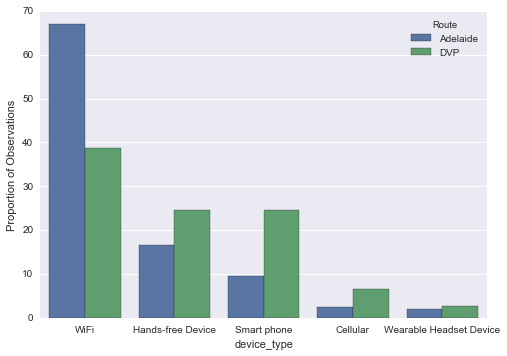

In [44]:
ax = sns.barplot(x='device_type', y="Proportion of Observations", hue='Route', data=dvp_adelaide)
ax.set_ylabel('Proportion of Observations')

The chart above shows a much greater proportion of WIFI devices on Adelaide --a major arterial with a protected bike-lane-- than on the DVP --a major expressway--. We can infer then that people travelling in non-car modes are more likely to have  WIFI devices enabled than a smart phone or cell phone with Bluetooth enabled. 

In [3]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,11,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '3 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

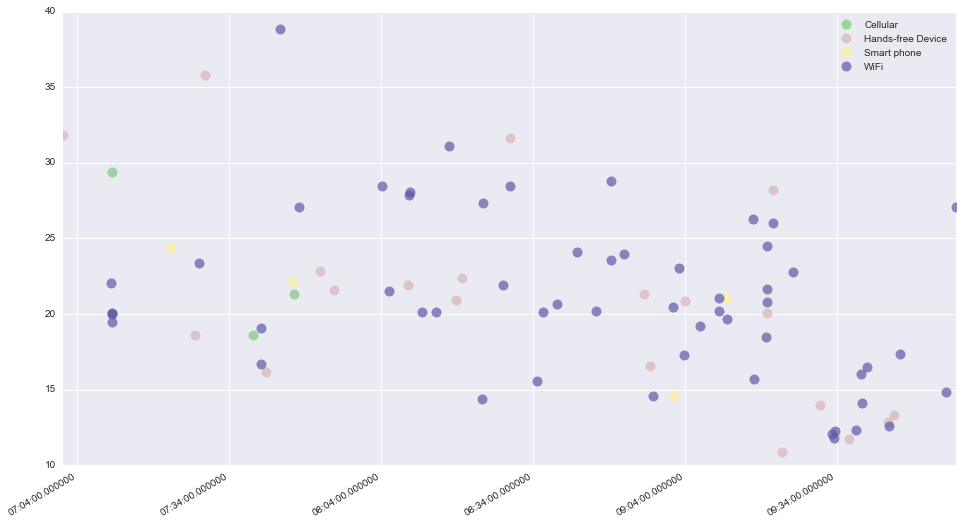

In [4]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

Looking at a few weekend days

In [8]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,10,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '8 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

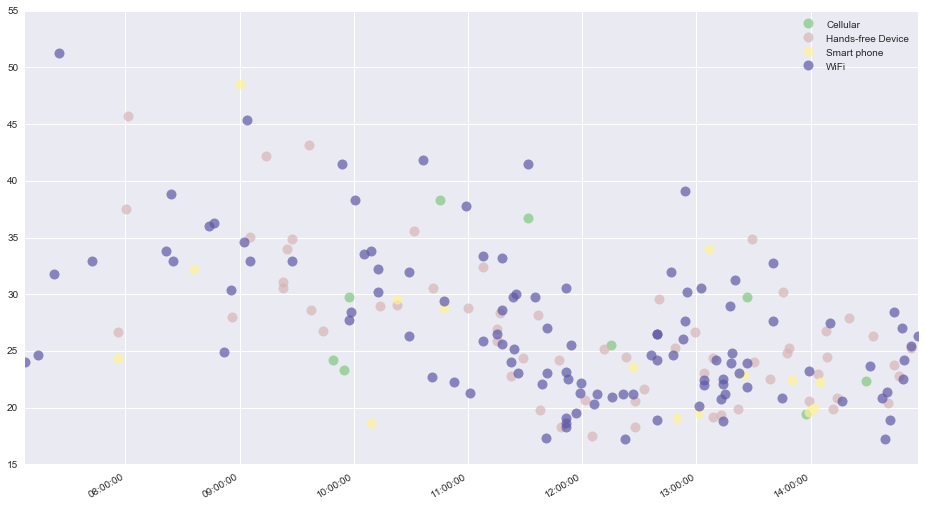

In [9]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

The scatter plots of individual dates don't show any detectable patterns between the 4 category of device. This would hint that it would be hard to determine whether real-time speeds are affected by cyclists or not. This next series of plots will attempt to detect trends over 1 month of data by using a swarm plot aggregated by 15-min bin.

In [11]:
test = datetime.time(7)

In [65]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.time(7))
sql = pg.SQL('''SELECT (EXTRACT(hour from measured_timestamp::TIME)::TEXT ||':'|| (trunc(EXTRACT(minute from measured_timestamp::TIME)/15)*15)::TEXT)::TIME as timebin,
3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '2 hour'
AND EXTRACT('isodow' FROM measured_timestamp) BETWEEN 2 and 4
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_october = pandasql.read_sql(sql, con)

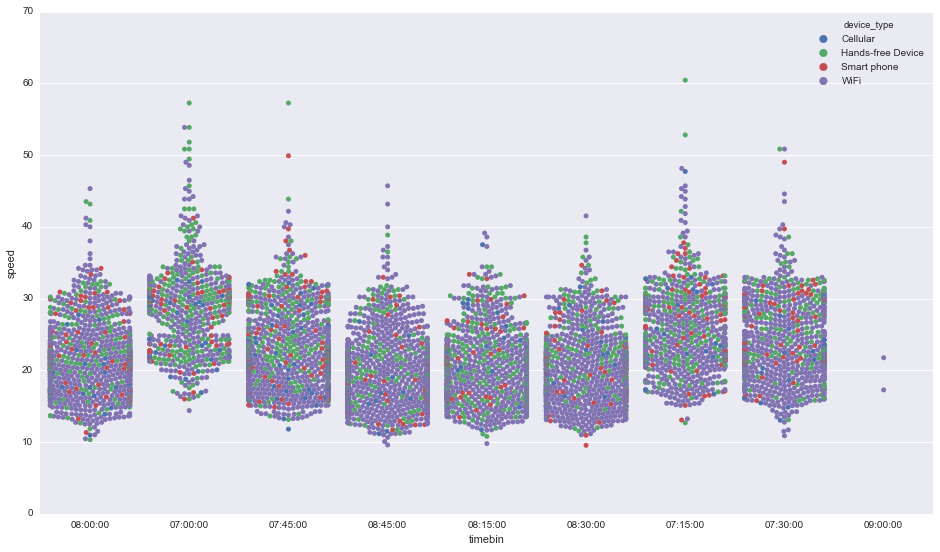

In [66]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.swarmplot(x='timebin', y='speed', hue='device_type', data=adelaide_october, ax=ax)

Since there's a bit too much data, let's have a better look at the distributions. Comparing the two main device types.

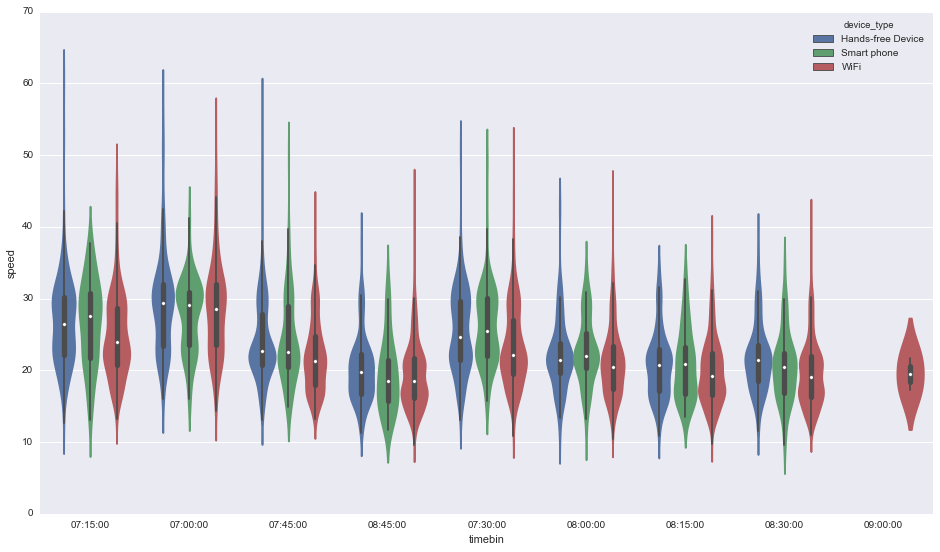

In [67]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device', 'Smart phone'])],
                        ax=ax)

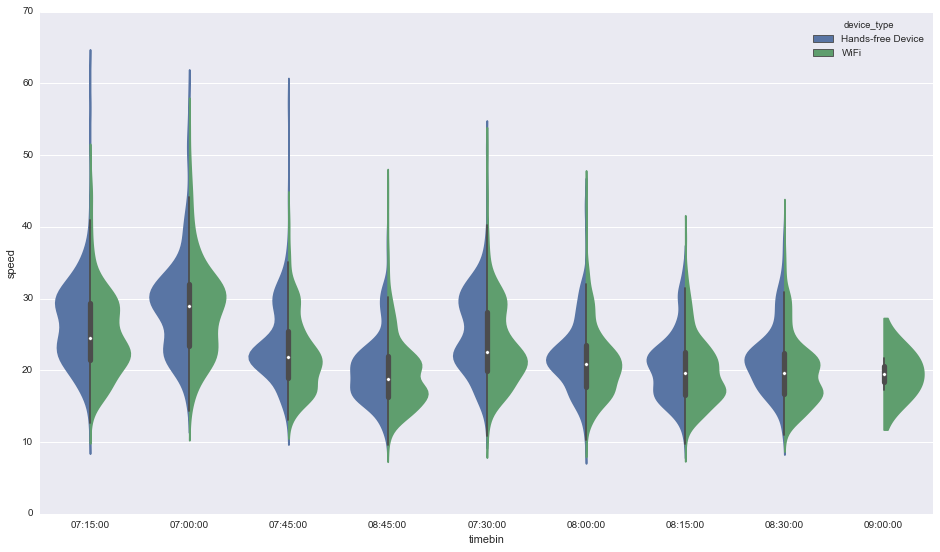

In [68]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device'])],
                        split=True, ax=ax)

In the plot above the WiFi class seems a little more bottom heavy than hands-free, implying it could have a higher proportion of slower vehicles, possibly cyclists. Now looking at the overall Midweek AM Peak for the four main device classes, the difference between the WiFi class and the others striking.

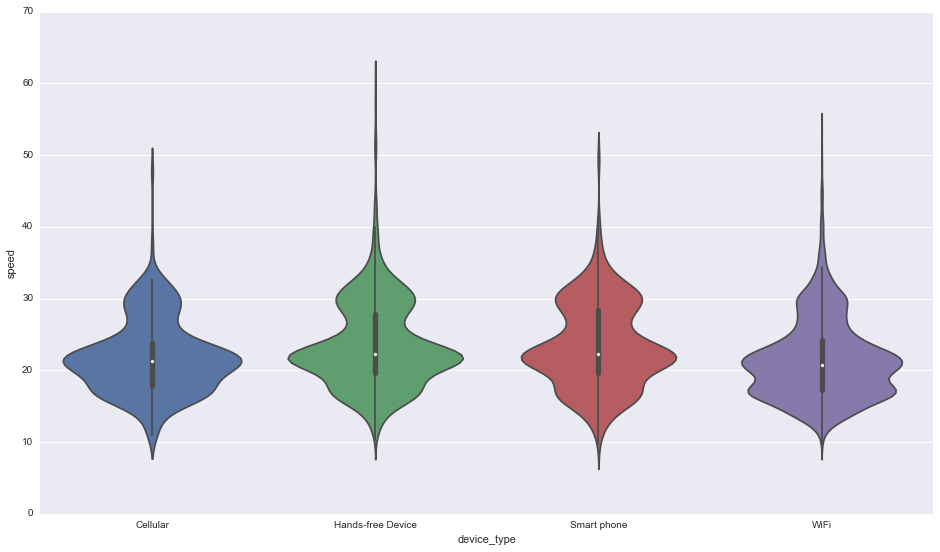

In [69]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='device_type', y='speed', data=adelaide_october, ax=ax)

Looking at a day of week comparison for the AM

In [61]:
startroad = pg.Literal('Adelaide')
analysis_hour = pg.Literal(datetime.time(7))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '2 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

adelaide_october_dow = pandasql.read_sql(sql, con)

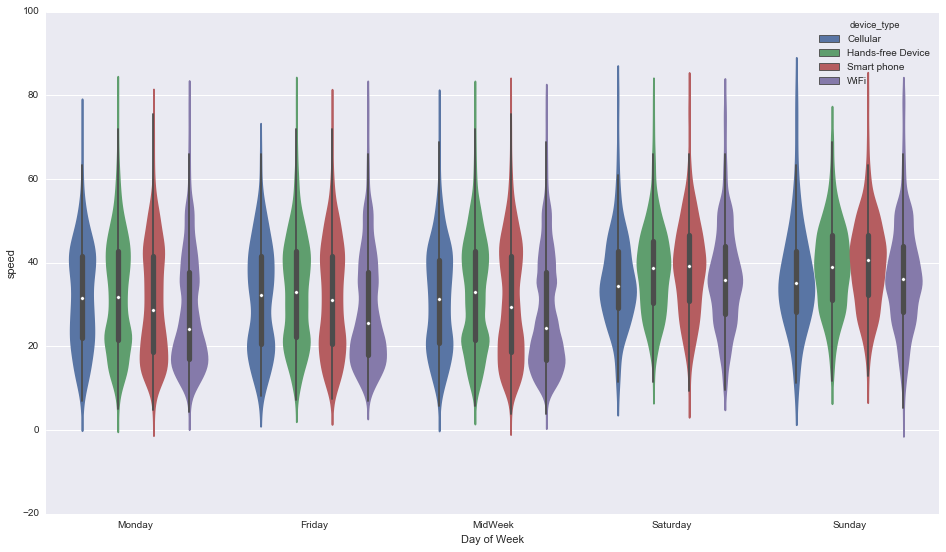

In [62]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=adelaide_october_dow, ax=ax)

Looking instead at Richmond in the PM 

In [63]:
startroad = pg.Literal('Richmond')
analysis_hour = pg.Literal(datetime.time(16))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '2 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

richmond_october_dow = pandasql.read_sql(sql, con)

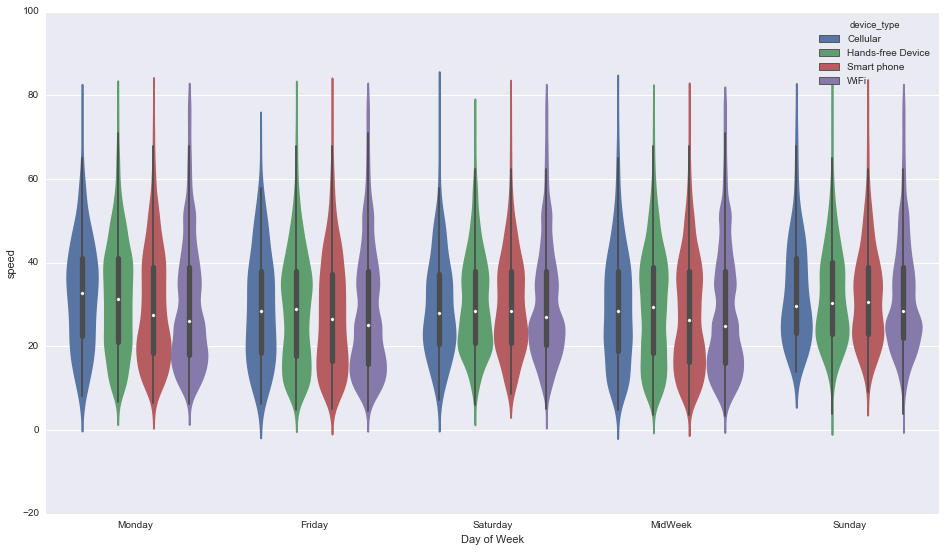

In [64]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=richmond_october_dow, ax=ax)